In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from six.moves import urllib

In [2]:
sess = tf.Session()

In [3]:
data_dir = 'temp'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')

if os.path.isfile(data_file):
    pass
else:
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    tarfile.open(filepath, 'r:gz').extractall(data_dir)

In [4]:
batch_size = 128
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

In [5]:
# Exponential Learning Rate Decay Params
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.

In [6]:
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length

In [7]:
def read_cifar_files(filename_queue, distort_images=True):
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
    
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]), [num_channels, image_height, image_width])
    
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    
    if distort_images:
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image, max_delta=63)
        final_image = tf.image.random_contrast(final_image, lower=0.2, upper=1.8)
        
    final_image = tf.image.per_image_standardization(final_image)
    return (final_image, image_label)

In [8]:
def input_pipline(batch_size, train_logical=True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1, 6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
        
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    # In tensorflow document, recommended size: 
    # min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000 
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity=capacity,
        min_after_dequeue=min_after_dequeue)
    
    return (example_batch, label_batch)

In [9]:
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    def truncated_normal_var(name, shape, dtype):
        return (tf.get_variable(name=name, shape=shape, dtype=dtype,
                               initializer=tf.truncated_normal_initializer(stddev=0.05)))
    
    def zero_var(name, shape, dtype):
        return (tf.get_variable(name=name, shape=shape, dtype=dtype,
                               initializer=tf.constant_initializer(0.0)))
    
    with tf.variable_scope('conv1') as scope:
        conv1_kernel = truncated_normal_var(name='conv_kernel1',
                                            shape=[5, 5, 3, 64],
                                            dtype=tf.float32)
        
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        relu_conv1 = tf.nn.relu(conv1_add_bias)
        
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer1')
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') as scope:
        conv2_kernel = truncated_normal_var(name='conv_kernel2',
                                            shape=[5, 5, 64, 64],
                                            dtype=tf.float32)
        
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        relu_conv2 = tf.nn.relu(conv2_add_bias)
        
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    with tf.variable_scope('full1') as scope:
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))
        
    with tf.variable_scope('full2') as scope:
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))
        
    with tf.variable_scope('full3') as scope:
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 = zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return (final_output)

In [10]:
def cifar_loss(logits, targets):
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return (cross_entropy_mean)

In [11]:
def train_step(loss_value, generation_num):
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num, num_gens_to_wait, lr_decay, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    train_step = optimizer.minimize(loss_value)
    
    return (train_step)

In [12]:
def accuracy_of_batch(logits, targets):
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    batch_pred = tf.cast(tf.argmax(logits, 1), tf.int32)
    predict_correctly = tf.equal(batch_pred, targets)
    accuracy = tf.reduce_mean(tf.cast(predict_correctly, tf.float32))
    return (accuracy)

In [13]:
images, targets = input_pipline(batch_size, train_logical=True)
test_images, test_targets = input_pipline(batch_size, train_logical=False)

In [14]:
with tf.variable_scope('model_definition') as scope:
    model_output = cifar_cnn_model(images, batch_size)
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)

In [15]:
loss = cifar_loss(model_output, targets)
accuracy = accuracy_of_batch(test_output, test_targets)

generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

In [16]:
init = tf.global_variables_initializer()
sess.run(init)

In [17]:
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-4, started daemon 123145549590528)>,
 <Thread(Thread-5, started daemon 123145554845696)>,
 <Thread(Thread-6, started daemon 123145560100864)>,
 <Thread(Thread-7, started daemon 123145565356032)>]

In [18]:
train_loss = []
test_accuracy = []

for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)
        
    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy= {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

Generation 50: Loss = 1.92457
Generation 100: Loss = 1.86472
Generation 150: Loss = 1.65734
Generation 200: Loss = 1.74366
Generation 250: Loss = 1.82194
Generation 300: Loss = 1.79592
Generation 350: Loss = 1.43502
Generation 400: Loss = 1.35306
Generation 450: Loss = 1.45037
Generation 500: Loss = 1.49546
 --- Test Accuracy= 56.25%.
Generation 550: Loss = 1.37202
Generation 600: Loss = 1.54253
Generation 650: Loss = 1.41182
Generation 700: Loss = 1.28541
Generation 750: Loss = 1.35896
Generation 800: Loss = 1.25353
Generation 850: Loss = 1.15399
Generation 900: Loss = 1.19973
Generation 950: Loss = 1.33850
Generation 1000: Loss = 1.16450
 --- Test Accuracy= 53.91%.
Generation 1050: Loss = 1.11620
Generation 1100: Loss = 1.32180
Generation 1150: Loss = 1.37570
Generation 1200: Loss = 1.05415
Generation 1250: Loss = 1.04877
Generation 1300: Loss = 0.95676
Generation 1350: Loss = 1.27770
Generation 1400: Loss = 1.00414
Generation 1450: Loss = 1.14115
Generation 1500: Loss = 1.06935
 ---

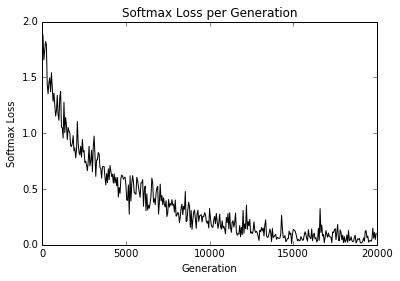

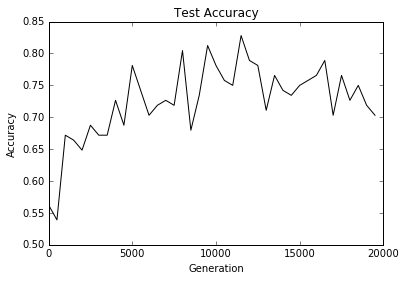

In [19]:
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()